In [1]:
from fastai.vision import *

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = Path('/content/drive/My Drive/Levis')
path_modal = path /'multimodal-search'


### Multilabel Classification

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path_modal, 'levis_multilabels_cleaned.csv')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128).databunch().normalize(imagenet_stats))

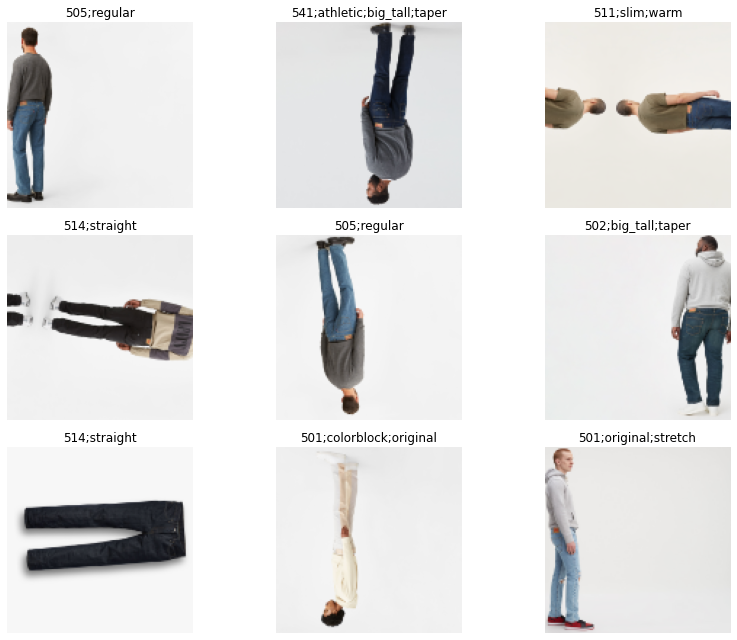

In [8]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch = models.resnet50
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [41]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


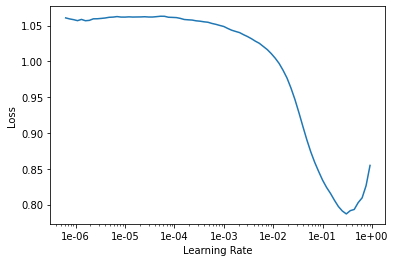

In [42]:
learn.recorder.plot()

In [0]:
lr = 0.01

In [44]:
learn.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,1.036924,0.988858,0.120906,0.170087,02:50
1,0.974305,0.943499,0.204532,0.199128,02:45
2,0.854873,0.404157,0.442836,0.219571,02:45
3,0.693304,0.172140,0.915351,0.210473,02:46
4,0.560863,0.173996,0.941959,0.167988,02:46
5,0.471534,0.174085,0.943421,0.152429,02:46
6,0.407490,0.171722,0.945760,0.157966,02:47
7,0.360642,0.170515,0.944883,0.161678,02:47


In [0]:
learn.save('levis_stage-1-rn50_v1')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


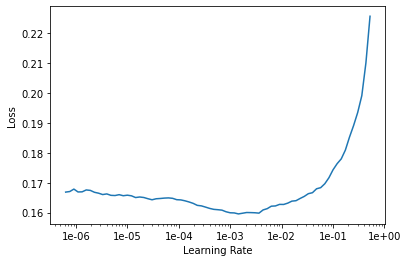

In [47]:
learn.lr_find()
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(8, slice(1e-5, lr/5))


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.164148,0.168621,0.942398,0.156631,03:16
1,0.161344,0.158188,0.938743,0.201420,03:16
2,0.157508,0.149783,0.929240,0.276803,03:19
3,0.153796,0.153373,0.931871,0.266174,03:19
4,0.149001,0.148335,0.928070,0.321423,03:22
5,0.144367,0.152336,0.930994,0.316936,03:18
6,0.140203,0.150446,0.933918,0.320497,03:17
7,0.136982,0.150121,0.934503,0.321666,03:18


In [49]:
learn.save('levis-stage-2-rn50', return_path=True)

PosixPath('/content/drive/My Drive/Levis/multimodal-search/models/levis-stage-2-rn50.pth')

In [0]:

data = (src.transform(tfms, size=256)
        .databunch(bs=8).normalize(imagenet_stats))

learn.data = data



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


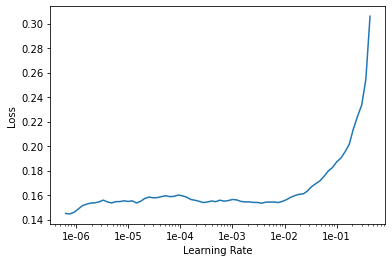

In [59]:

learn.freeze()
learn.lr_find()
learn.recorder.plot()


In [0]:
lr=1e-2/2


In [61]:
learn.fit_one_cycle(5, slice(lr))


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.155119,0.163278,0.931433,0.234927,06:54
1,0.166941,0.171289,0.934503,0.240879,06:50
2,0.168360,0.155300,0.929094,0.323738,06:52
3,0.153045,0.149215,0.938743,0.334012,06:50
4,0.138357,0.145475,0.938889,0.325773,06:51


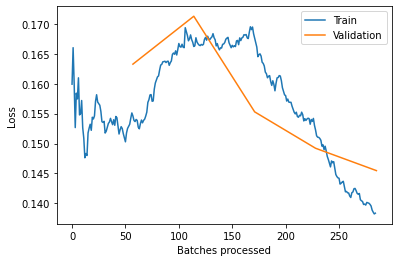

In [62]:
learn.recorder.plot_losses()

In [63]:
learn.save('levis-stage-2-rn50-256', return_path=True)

PosixPath('/content/drive/My Drive/Levis/multimodal-search/models/levis-stage-2-rn50-256.pth')

In [64]:
learn.save('levis-stage-2-rn50-256-torch',with_opt=False, return_path=True)

PosixPath('/content/drive/My Drive/Levis/multimodal-search/models/levis-stage-2-rn50-256-torch.pth')

In [0]:
learn.save('levis-stage-2-rn50-512', return_path=True)
learn.save('levis-stage-2-rn50-512-torch',with_opt=False, return_path=True)


### Inference

In [0]:

learn.load('levis-stage-2-rn50-256')
learn.export()

In [112]:
test1 = ImageList.from_folder(path_modal/'test')
len(test1)


11

In [0]:
learn = load_learner(learn.path,test=test1)

In [102]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]



In [104]:
labelled_preds[:]

['502 lo_ball original straight taper',
 'taper',
 '502 big_tall flex slim straight taper',
 '1993 501 slim taper',
 '502 514 big_tall relaxed straight taper',
 '1955 501 original slim taper',
 '541 flex taper',
 '502 514 straight',
 '502 slim taper',
 '501',
 'flex straight']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [106]:
fnames

['502_taper',
 '541_athletic_taper_flex',
 '510_skinny_flex',
 '502_taper_flex',
 '514_straight_flex',
 '502_slim_taper_flex',
 '541_athletic_taper_big_tall',
 '512_slim_taper_1',
 '512_slim_taper',
 '501_1993_straight',
 '541_athletic_taper_flex_1']

In [0]:
labels = [label.replace('_',' ') for label in fnames]

In [107]:
labels[6] = labels[6].replace('big tall','big_tall')
labels[7] = labels[7].replace(' 1','')
labels[10] = labels[10].replace('flex1','flex')
labels

['502 taper',
 '541 athletic taper flex',
 '510 skinny flex',
 '502 taper flex',
 '514 straight flex',
 '502 slim taper flex',
 '541 athletic taper big_tall',
 '512 slim taper',
 '512 slim taper',
 '501 1993 straight',
 '541 athletic taper flex']

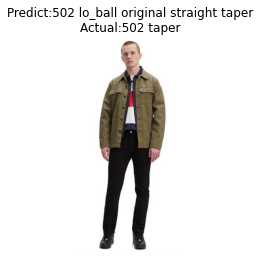

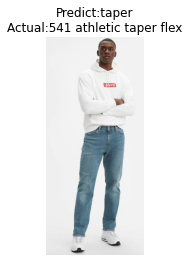

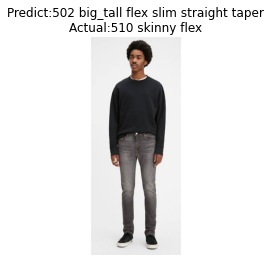

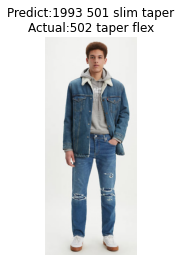

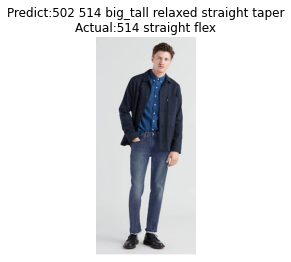

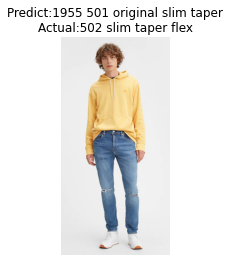

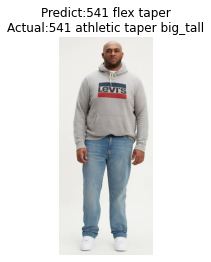

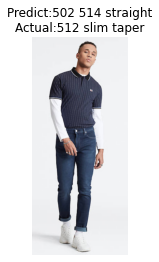

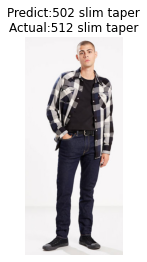

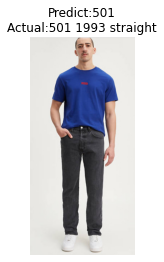

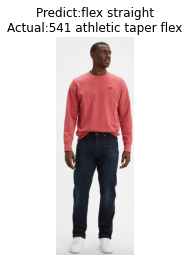

In [132]:
for i in range(len(test1)):
  img = open_image(test1.items[i])
  img.show(figsize=(4, 4), title='Predict:'+labelled_preds[i]+'\nActual:'+labels[i])
